In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import func, create_engine, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
#inspect measurement schema
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Print first row in measurement table
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x26012a355c0>,
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01',
 'prcp': 0.08,
 'station': 'USC00519397'}

In [12]:
#inspect station columns
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
# Print first row in station table
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x26012a557b8>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397',
 'elevation': 3.0,
 'latitude': 21.2716,
 'id': 1}

# Step 1 - Climate Analysis and Exploration

# Precipitation Analysis

In [14]:
# Grab the latest date entry in the data table
last_entry = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_entry

('2017-08-23')

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_tweleve = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= "2016-08-23").\
       order_by(Measurement.date).all()

In [16]:
# Calculate the date 1 year ago from the last data point in the database
last_year_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
last_year_date

datetime.date(2016, 8, 23)

In [17]:
# Save the query results as a Pandas DataFrame and set the index to the date column
climate_df = pd.DataFrame(last_tweleve)
climate_df.set_index('date').head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


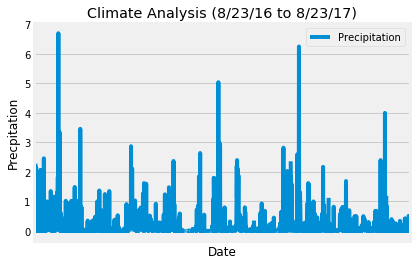

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
climate_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Precpitation")
plt.title("Climate Analysis (8/23/16 to 8/23/17)")
plt.legend(["Precipitation"])
plt.xticks([]) #Removes x-axis values
plt.show()

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
climate_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [20]:
# Design a query to show how many stations are available in this dataset?
stations_count = session.query(Station).count()
print(f"There are a total of {stations_count} stations available in this dataset")

There are a total of 9 stations available in this dataset


In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_list = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())
station_list

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
active_station = station_list[0][0] #First row and first column

lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == active_station).all()
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == active_station).all()
average_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == active_station).all()

print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp} ")
print(f"Average Temperature: {average_temp} ")

Lowest Temperature: [(54.0,)]
Highest Temperature: [(85.0,)] 
Average Temperature: [(71.66378066378067,)] 


In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_list_one = (session.query(Measurement.date, Measurement.tobs) 
                   .filter(Measurement.date > last_year_date) 
                   .filter(Measurement.station == active_station) 
                   .order_by(Measurement.date) 
                   .all())

In [24]:
#convert query object to data frame
station_df = pd.DataFrame(station_list_one)
station_df.set_index('date').head()

,tobs
date,
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0


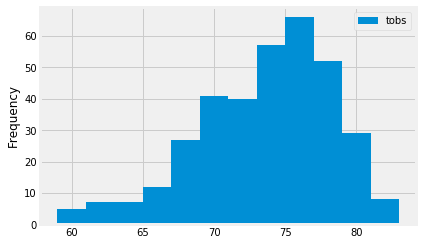

In [46]:
#histogram plot with pandas
station_df.plot(kind='hist', bins=12)

# Step 2 - Climate App

In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [27]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2016-08-23', '2017-08-23')
trip_temps 
 

[(58.0, 74.59058295964125, 87.0)]

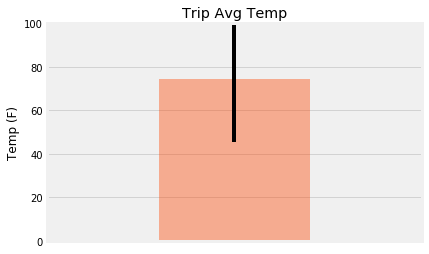

In [37]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

tmin = trip_temps [0][0] #58.0
tavg = trip_temps [0][1] #74.59
tmax = trip_temps [0][2] #87.0

error = tmax-tmin

plt.bar(0,tavg, yerr=error, color = 'orangered', alpha = .4)
plt.ylim(0, 100)
plt.xlim(-1, 1)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.xticks([])
plt.grid(alpha=.8)

In [41]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

#query for precipitation per station on trip dates
sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation,Measurement.prcp]

station_query = (session.query(*sel)
                   .filter(Station.station == Measurement.station)
                   .filter(Measurement.date >= '2016-08-23')
                   .group_by(Station.station)
                   .order_by((Measurement.prcp).desc())
                   .all())

#convert query object to data frame
stationfinal_df = pd.DataFrame(np.array(station_query))

#rename columns
stationfinal_df = stationfinal_df.rename(columns={0: "Station", 
                                                    1: "Location", 
                                                    2: "Latitude", 
                                                    3: "Longitude", 
                                                    4: "Elevation", 
                                                    5: "Total Precipitation"})

stationfinal_df

,Station,Location,Latitude,Longitude,Elevation,Total Precipitation
0,USC00519281,"WAIHEE 837.5, HI US",21.4517,-157.849,32.9,1.79
1,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.803,152.4,0.7
2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.802,14.6,0.15
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.837,7,0.05
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.3356,-157.711,19.5,0.02
5,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.817,3,0
6,USC00517948,"PEARL CITY, HI US",21.3934,-157.975,11.9,None


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
